#  Laboratorio  Dirigido #3: Introducción a redes neuronales con Keras

En este laboratorio vamos a realizar clasificadores de texto utilizando redes neuronales. Vamos a utlizar el framework de tensorflow (https://www.tensorflow.org/) y la libreria keras (https://keras.io/).

# Dataset

Iniciemos revisando el dataset. Descargue descomprima y cargue a colab los siguientes archivos:

*   amazon_cells_labelled
*   imdb_labelled
*   yelp_labelled

Lea la documentación para entender el proposito del dataset:
https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [6]:
## Carga del dataset
filepath_dict = {'yelp':   'yelp_labelled.txt',
                 'amazon': 'amazon_cells_labelled.txt',
                 'imdb':   'imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

## Cada ejemplo de entrenamiento esta compuesto por el texto (sentence), fuente (source), y el label (1-positivo, 0-negativo)
df = pd.concat(df_list)
print(df.iloc[0])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


# Baseline model

In [7]:
## Vamos a crear una linea-base usando regresión logistica.
## Recuerde que una linea base es un modelo simple que sirve para comparar que tan buenos/malos son otros modelos.
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

    #No realizamos todos los procesos de procesamiento que realizamos en los laboratorios pasados,
    ##ya que nuestro objetivo es simplemente obtener unos resultados que nos permitan compararnos.
    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    predictions_log = classifier.predict(X_test)
    print("----------", source, "-----------")
    print('Accuracy score: ', format(accuracy_score(y_test, predictions_log)))
    print('Precision score: ', format(precision_score(y_test, predictions_log)))
    print('Recall score: ', format(recall_score(y_test, predictions_log)))
    print('F1 score: ', format(f1_score(y_test, predictions_log)))

---------- yelp -----------
Accuracy score:  0.796
Precision score:  0.8319327731092437
Recall score:  0.7615384615384615
F1 score:  0.7951807228915662
---------- amazon -----------
Accuracy score:  0.796
Precision score:  0.8099173553719008
Recall score:  0.7777777777777778
F1 score:  0.7935222672064778
---------- imdb -----------
Accuracy score:  0.7486631016042781
Precision score:  0.7156862745098039
Recall score:  0.8021978021978022
F1 score:  0.756476683937824


Los resultados de la linea base son interesantes, entre el 75% y 80% del F1-score. Ahora vamos a construir modelos mas sofisticados utilizando redes neuronales y evaluar que tanto mejoramos la linea base.

# Keras

### Definition (https://keras.io/)
Keras es una API diseñada para seres humanos, no para máquinas. Keras sigue las mejores prácticas para reducir la carga cognitiva: ofrece API consistentes y simples, minimiza la cantidad de acciones del usuario requeridas para casos de uso comunes de redes neuronales y proporciona mensajes de error claros y procesables. También tiene una extensa documentación y guías para desarrolladores.


In [8]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

Keras viene con unas funcionalidades pre-establecidas interesantes para representación de texto. Nos interesa particularmente la capa denominada TextVectorization, que incorpora un conjunto de funciones para transformar texto a representaciónes vectoriales. En particular esta capa permite:

1. Estandarizar cada documento (generalmente minúsculas + eliminación de puntuación) .
2. Dividir cada muestra en subcadenas (generalmente palabras).
3. Recombinar subcadenas en tokens (generalmente ngramas).
4. Construir un vocabulario (asociar un valor int único con cada token).
5. Transformar cada muestra utilizando este índice, ya sea en un vector de enteros o en un vector flotante denso.

Pueden ver un resumen del proceso en la siguiente imagen.

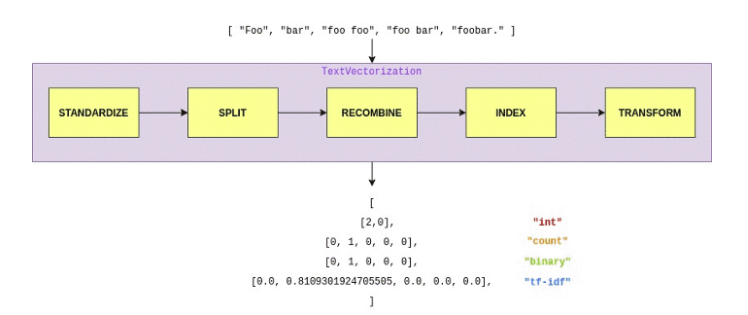

https://towardsdatascience.com/you-should-try-the-new-tensorflows-textvectorization-layer-a80b3c6b00ee

In [9]:

vectorize_layer = TextVectorization(
    ngrams=None,
    max_tokens=500, vocabulary=None,
    output_mode='binary', output_sequence_length=None, pad_to_max_tokens=True,
)
# Parámetros importantes (seleccionados de la documentación):
# standardize='lower_and_strip_punctuation'
# split='split_on_whitespace'
# output_sequence_length only valid for int output mode to create a tensor of size [batch_size, output_sequence_length]
# pad_to_max_tokens  only valid in binary, count, and tf-idf modes. The output will have its feature axis padded to max_tokens
# even if the number of unique tokens in the vocabulary is less than max_tokens.


## Modelo 1

Nuestro primer modelo va a ser uno básico. Vamos a realizar una codificación de bolsa de palabras como representación del texto y lo pasaremos a través de un conjunto de capas densas.

En la siguiente gráfica se muestra el modelo que queremos construir:

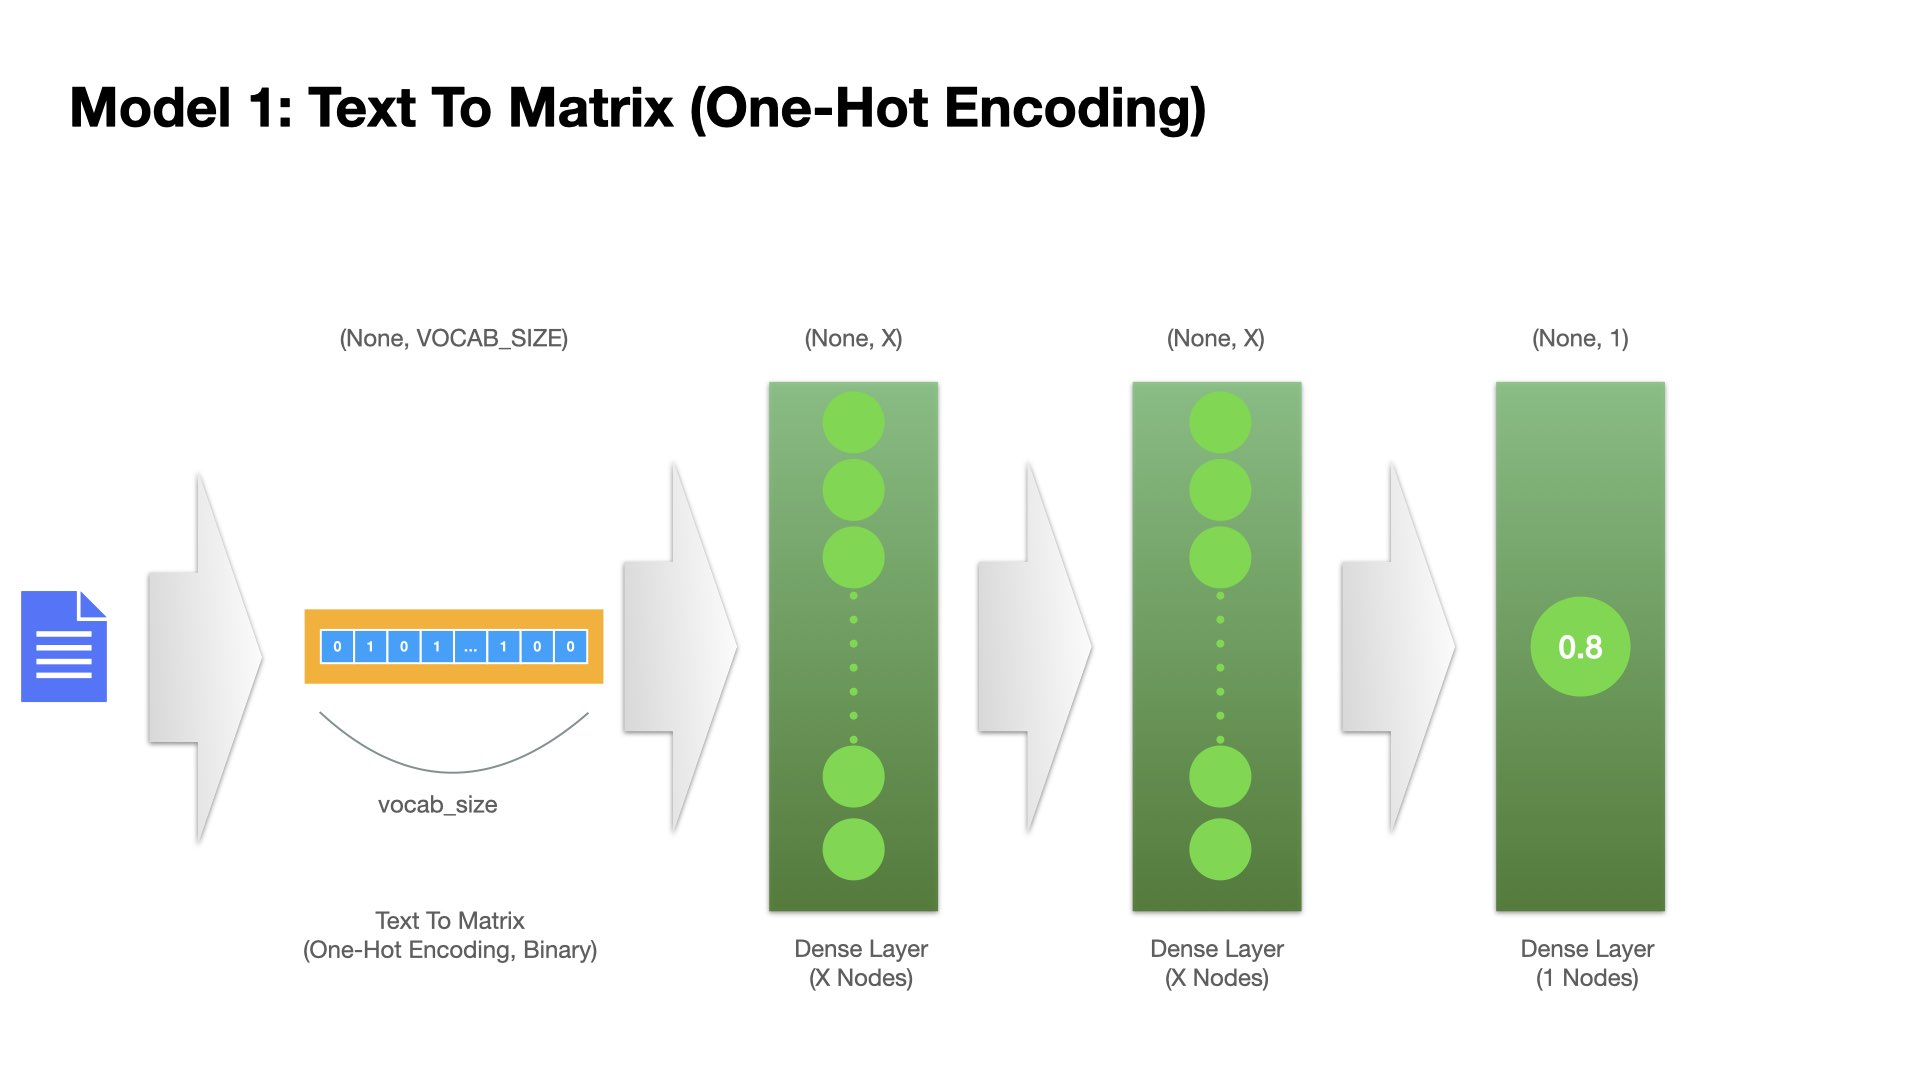

In [10]:
df_yelp = df[df['source'] == 'yelp']
sentences = df_yelp['sentence'].values
y = df_yelp['label'].values
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)


# Una vez que tenemos nuestros identificadores, formateamos los conjuntos de datos en un compatible con Keras-fit
# formato: una tupla de la forma (text_data, label).
train_dataset = tf.data.Dataset.from_tensor_slices((sentences_train,y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((sentences_test,y_test))


# También creamos un conjunto de datos con solo los datos textuales. Esto sera usado
# para construir nuestro vocabulario más adelante.
text_dataset = tf.data.Dataset.from_tensor_slices((sentences_train))



In [11]:
# Ahora que se ha creado la capa de vocabulario, llamamos a `adapt`
# conjunto de datos para crear el vocabulario
vectorize_layer.adapt(text_dataset.batch(64))

In [12]:
##CAPAS DE LA RED NEURONAL


# Comience creando una capa de entrada. Debe tener una forma de
# (1,) (porque necesitamos garantizar que hay exactamente un documento
text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')


# La primera capa de nuestro modelo es la capa de vectorización que ya definimos
# previamente. A la salida de esta capa, vamos a tener
# un tensor de tamaño (batch_size, max_len) que contiene índices de vocabulario.


x = vectorize_layer(text_input)

# Luego vamos a poner una única capa densa de 10 neuronas con
# una función de activación relu. Seleccionamos relu debido a que }
# agiliza el entrenamiento.
x = layers.Dense(2, activation='relu')(x)

# Proyectamos en una capa de salida de una sola unidad y lo convertimos en probabilidad con un sigmoide:
predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
model = tf.keras.Model(text_input, predictions)

# Compilar el modelo con función crossentropy loss y optimizador adam.
# https://keras.io/api/losses/
# https://keras.io/api/optimizers/
# Ojo con las metricas ya que el entrenamiento es en batches
# https://keras.io/api/models/model_training_apis/
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
batch_size = 32
epochs = 100

# Fit the model using the train and test datasets.
history = model.fit(
    train_dataset.batch(batch_size),
    validation_data=test_dataset.batch(batch_size),
    epochs=epochs)

Epoch 1/100
24/24 [==============================] - 1s 8ms/step - loss: 0.6921 - accuracy: 0.4933 - val_loss: 0.6895 - val_accuracy: 0.5040
Epoch 2/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6862 - accuracy: 0.5200 - val_loss: 0.6863 - val_accuracy: 0.5480
Epoch 3/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6800 - accuracy: 0.6013 - val_loss: 0.6817 - val_accuracy: 0.5720
Epoch 4/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6710 - accuracy: 0.6387 - val_loss: 0.6754 - val_accuracy: 0.5800
Epoch 5/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6592 - accuracy: 0.6680 - val_loss: 0.6686 - val_accuracy: 0.5800
Epoch 6/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6451 - accuracy: 0.7040 - val_loss: 0.6603 - val_accuracy: 0.6120
Epoch 7/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6297 - accuracy: 0.7280 - val_loss: 0.6510 - val_accuracy: 0.6440
Epoch 8/100
2

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 500)               0         
 ctorization)                                                    
                                                                 
 dense (Dense)               (None, 2)                 1002      
                                                                 
 predictions (Dense)         (None, 1)                 3         
                                                                 
Total params: 1005 (3.93 KB)
Trainable params: 1005 (3.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


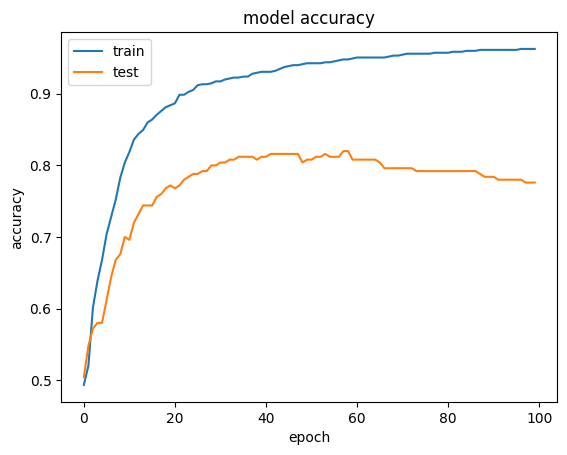

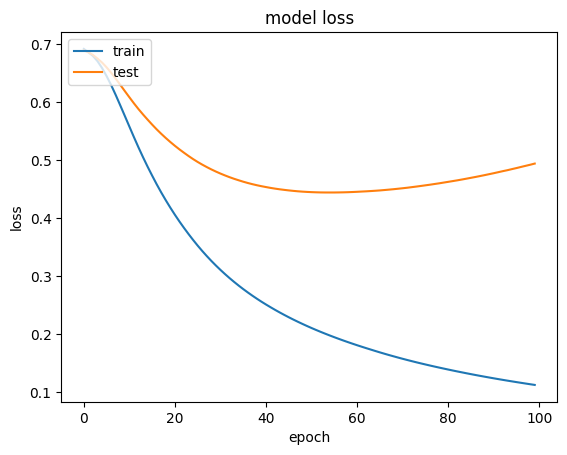

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Alternativa para facilitar construcción de modelos en keras: Sequential

In [16]:
from keras.models import Sequential

In [17]:
## Con sequetial podemos construir una red neuronal apilando capas
modelsequ = Sequential()
modelsequ.add(tf.keras.Input(shape=(1,), dtype=tf.string))
modelsequ.add(vectorize_layer)
modelsequ.add(layers.Dense(10, activation='relu'))
modelsequ.add(layers.Dense(1, activation='sigmoid'))
modelsequ.compile(loss='binary_crossentropy',  optimizer='adam', metrics=['accuracy'])
modelsequ.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 500)               0         
 ctorization)                                                    
                                                                 
 dense_1 (Dense)             (None, 10)                5010      
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 5021 (19.61 KB)
Trainable params: 5021 (19.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
historyseq = modelsequ.fit(
    train_dataset.batch(batch_size),
    validation_data=test_dataset.batch(batch_size),
    epochs=epochs)

Epoch 1/100
24/24 [==============================] - 1s 8ms/step - loss: 0.6898 - accuracy: 0.5400 - val_loss: 0.6789 - val_accuracy: 0.6160
Epoch 2/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6639 - accuracy: 0.6640 - val_loss: 0.6676 - val_accuracy: 0.6560
Epoch 3/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6387 - accuracy: 0.7347 - val_loss: 0.6535 - val_accuracy: 0.6800
Epoch 4/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6093 - accuracy: 0.7907 - val_loss: 0.6361 - val_accuracy: 0.6800
Epoch 5/100
24/24 [==============================] - 0s 2ms/step - loss: 0.5754 - accuracy: 0.8267 - val_loss: 0.6160 - val_accuracy: 0.7080
Epoch 6/100
24/24 [==============================] - 0s 2ms/step - loss: 0.5392 - accuracy: 0.8387 - val_loss: 0.5945 - val_accuracy: 0.7320
Epoch 7/100
24/24 [==============================] - 0s 2ms/step - loss: 0.5024 - accuracy: 0.8573 - val_loss: 0.5738 - val_accuracy: 0.7360
Epoch 8/100
2

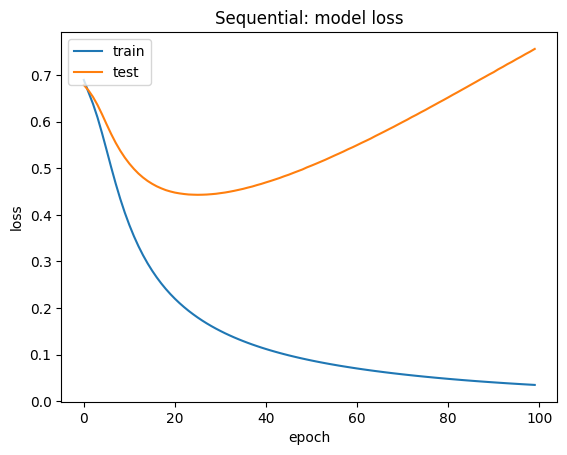

In [19]:
plt.plot(historyseq.history['loss'])
plt.plot(historyseq.history['val_loss'])
plt.title('Sequential: model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Como agregamos capas Dropout

In [20]:
modelsequ2 = Sequential()
modelsequ2.add(tf.keras.Input(shape=(1,), dtype=tf.string))
modelsequ2.add(vectorize_layer)
modelsequ2.add(layers.Dense(10, activation='relu'))
modelsequ2.add(layers.Dropout(0.5))
modelsequ2.add(layers.Dense(1, activation='sigmoid'))
modelsequ2.compile(loss='binary_crossentropy',  optimizer='adam', metrics=['accuracy'])
modelsequ2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 500)               0         
 ctorization)                                                    
                                                                 
 dense_3 (Dense)             (None, 10)                5010      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 5021 (19.61 KB)
Trainable params: 5021 (19.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
modelsequ2.fit(
    train_dataset.batch(batch_size),
    validation_data=test_dataset.batch(batch_size),
    epochs=epochs)

Epoch 1/100
24/24 [==============================] - 1s 10ms/step - loss: 0.6928 - accuracy: 0.5120 - val_loss: 0.6877 - val_accuracy: 0.5280
Epoch 2/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6776 - accuracy: 0.5613 - val_loss: 0.6808 - val_accuracy: 0.5760
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.6280 - val_loss: 0.6727 - val_accuracy: 0.6160
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 0.7027 - val_loss: 0.6614 - val_accuracy: 0.6560
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6773 - val_loss: 0.6498 - val_accuracy: 0.6760
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6143 - accuracy: 0.7067 - val_loss: 0.6367 - val_accuracy: 0.7040
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5974 - accuracy: 0.7373 - val_loss: 0.6234 - val_accuracy: 0.7240
Epoch 8/100


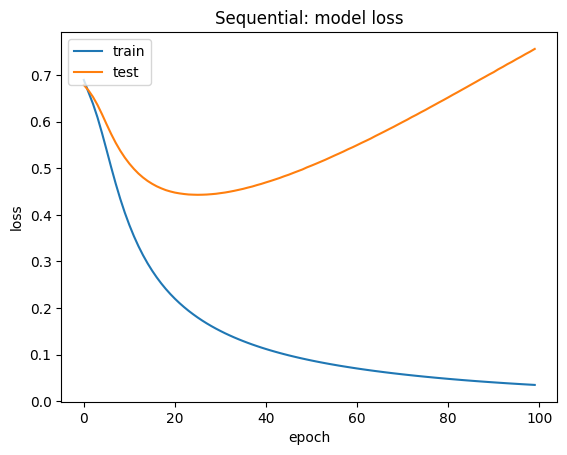

In [22]:
plt.plot(historyseq.history['loss'])
plt.plot(historyseq.history['val_loss'])
plt.title('Sequential: model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Ejercicio
- Juegue con la arquitectura de la red para llegar a el valor mas alto de accuracy en validación posible. Aumente/reduzca las capas, agregue/reduzca neuronas por capa, agregue/quite capas de dropout. Recuerde que al cabiar la arquitectura es importante saber el punto donde el modelo empieza a realizar overfitting.